In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import squarify
import matplotlib
import scipy.stats as stats
import os

os.chdir('../')
from src import helper

plt.style.use('ggplot') # check out some other plot styles!

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial look at our data

In [5]:
crime = pd.read_csv('../Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
crime.head(10)
crime.columns

Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId',
       'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods',
       'DELETE - Fire Prevention Districts', 'DELETE - Police Districts',
       'DELETE - Supervisor Districts', 'DELETE - Zip Codes',
       'DELETE - Neighborhoods', 'DELETE - 2017 Fix It Zones',
       'Civic Center Harm Reduction Project Boundary',
       'Fix It Zones as of 2017-11-06 ', 'DELETE - HSOC Zones',
       'Fix It Zones as of 2018-02-07',
       'CBD, BID and GBD Boundaries as of 2017',
       'Areas of Vulnerability, 2016', 'Central Market/Tenderloin Boundary',
       'Central Market/Tenderloin Boundary Polygon - Updated',
       'HSOC Zones as of 2018-06-05', 'OWED Public Spaces'],
      dtype='object')

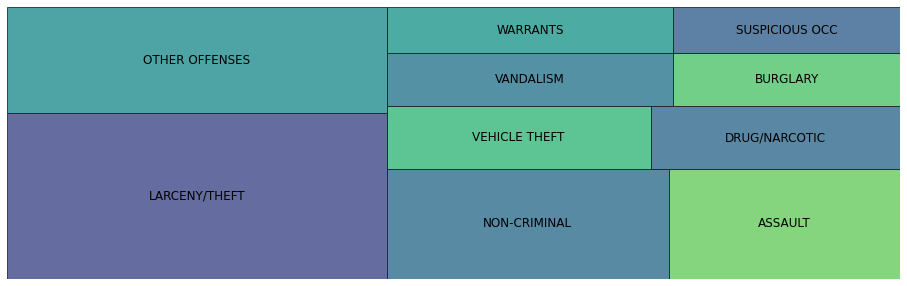

In [6]:
#Tree-mapping of top 10 crimes by category and description
top_10 = crime.groupby('Category').count().sort_values(by='Descript', ascending=False)['Descript'].head(10)

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 5)
          
squarify.plot(sizes=list(top_10), label=list(top_10.index),alpha=.8, text_kwargs={'fontsize':12}, bar_kwargs=dict(linewidth=1, edgecolor="#222222"))
plt.axis('off')
#plt.savefig('crimetreecat.png', dpi=350)


# Analysis and plotting from data extracted from sfcrime database

First, let's get all our data

In [7]:
# Read in all our data
crime_2003 = pd.read_csv('data/2003.csv')
crime_2004 = pd.read_csv('data/2004.csv')
crime_2005 = pd.read_csv('data/2005.csv')
crime_2006 = pd.read_csv('data/2006.csv')
crime_2007 = pd.read_csv('data/2007.csv')
crime_2008 = pd.read_csv('data/2008.csv')
crime_2009 = pd.read_csv('data/2009.csv')
crime_2010 = pd.read_csv('data/2010.csv')
crime_2011 = pd.read_csv('data/2011.csv')
crime_2012 = pd.read_csv('data/2012.csv')
crime_2013 = pd.read_csv('data/2013.csv')
crime_2014 = pd.read_csv('data/2014.csv')
crime_2015 = pd.read_csv('data/2015.csv')
crime_2016 = pd.read_csv('data/2016.csv')
crime_2017 = pd.read_csv('data/2017.csv')

auto_crime = pd.read_csv('data/auto_crime.csv')
auto_crime
mission_crime = pd.read_csv('data/mission_crime.csv')
mission_crime

crime_years = [crime_2003, crime_2004, crime_2005, crime_2006, crime_2007, crime_2008, 
               crime_2009, crime_2010, crime_2011, crime_2012, crime_2013, crime_2014, 
               crime_2015, crime_2016, crime_2017]

years = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
         '2013', '2014', '2015', '2016', '2017']

## Looking at violent vs non-violent crime
Is violent crime resolved at a higher rate than non-violent crime?

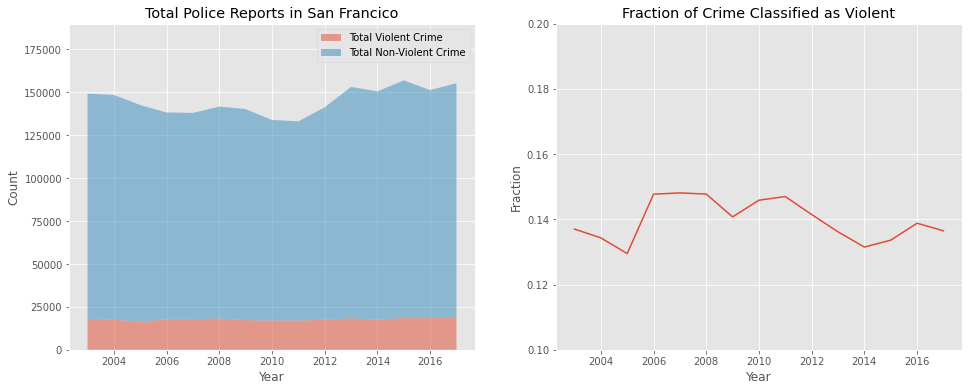

In [8]:
# Look at overall crime rate -> this is in mission crime csv
mission_crime['Total Violent Crime'] = mission_crime['viol_in_mission'] + mission_crime['viol_ex_mission']
mission_crime['Total Non-Violent Crime'] = mission_crime['nonviol_in_mission'] + mission_crime['nonviol_ex_mission']
mission_crime['Fraction'] = mission_crime['Total Violent Crime']/mission_crime['Total Non-Violent Crime']


fig, axes = plt.subplots(1,2, figsize=(16,6))

ax = axes[0]
ax.stackplot(mission_crime['year'], mission_crime['Total Violent Crime'],
              mission_crime['Total Non-Violent Crime'], 
              labels=['Total Violent Crime', 'Total Non-Violent Crime'], alpha=0.5)
ax.legend()
ax.set_title('Total Police Reports in San Francico')
ax.set_ylabel('Count')
ax.set_xlabel('Year')
ax.set_ylim(0,190000)


ax = axes[1]
ax.plot(mission_crime['year'], mission_crime['Fraction'])
ax.set_title('Fraction of Crime Classified as Violent')
ax.set_ylabel('Fraction')
ax.set_xlabel('Year')
ax.set_ylim(0.1, 0.2)

plt.savefig('crime_in_sf.png', dpi=350)



In [9]:
# Resolution of crimes by violent or non-violent
results = pd.DataFrame()
vres = []
nres = []

for year, data in zip(years, crime_years):
    vfrac, nvfrac = helper.vresolution(data)
    vres.append(vfrac)
    nres.append(nvfrac)

vres = pd.Series(vres)
nres = pd.Series(nres)
resolved = pd.DataFrame({'Year': pd.Series(years), 'Violent Resolved': vres, 'Non-violent Resolved': nres})

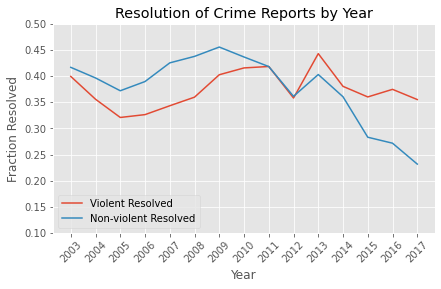

In [10]:
# Plot
helper.plotter_onegraph(resolved, 'Year', ['Violent Resolved', 'Non-violent Resolved'])
plt.ylabel('Fraction Resolved')
plt.title('Resolution of Crime Reports by Year')
plt.xticks(rotation=45)
plt.ylim(0.1, 0.5)
fig.tight_layout()
plt.subplots_adjust(top=.88)
plt.savefig('resolution.png', bbox_inches='tight', dpi=350)


## Theft from cars from 2003-2017

My hypothesis is that thefts from cars will increase > 10% after 2014 relative to the years before 2014. 

That hypothesis seems to only be partially correct: thefts from cars started increasing ~2011 and continued to increase almost every year after that. 

How to quantify this? Calculate average car theft rate from 2003-2014 (mean and std) and compare to 2015-2017? 

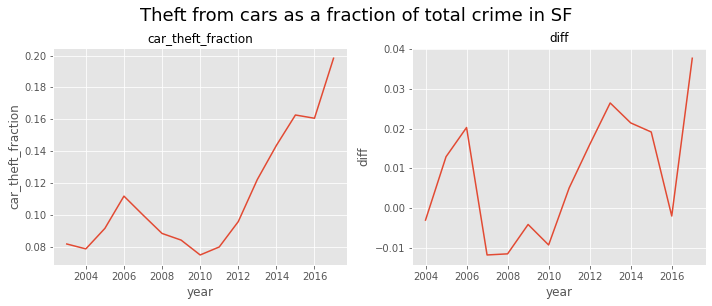

In [11]:
# Plot thefts from cars as a fraction of total crime
title = "Theft from cars as a fraction of total crime in SF"
helper.plotter(auto_crime, 'year', ['car_theft_fraction', 'diff'], title=title)

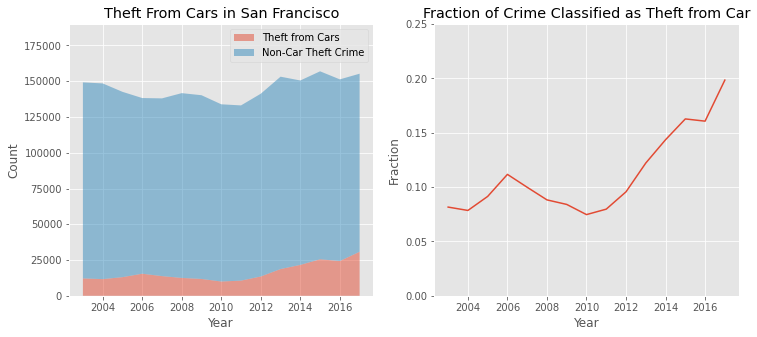

In [12]:
# Plot total crime, total thefts, and fraction all on one plot

not_auto_crime = auto_crime['total_crime_ct'] - auto_crime['car_theft_tot_ct']

fig, axes = plt.subplots(1,2, figsize=(12,5))

ax = axes[0]           
ax.stackplot(auto_crime['year'], auto_crime['car_theft_tot_ct'], not_auto_crime, labels=['Theft from Cars', 'Non-Car Theft Crime'], alpha=0.5)
ax.legend()
ax.set_title('Theft From Cars in San Francisco')
ax.set_ylabel('Count')
ax.set_xlabel('Year')
ax.set_ylim(0,190000)

ax = axes[1]
ax.plot(auto_crime['year'], auto_crime['car_theft_fraction'])
ax.set_title('Fraction of Crime Classified as Theft from Car')
ax.set_ylabel('Fraction')
ax.set_xlabel('Year')
ax.set_ylim(0, 0.25)


plt.savefig('car_theft.png', bbox_inches='tight', dpi=350)


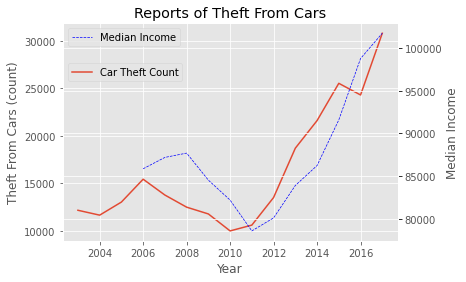

In [13]:
# Plot car thefts fraction with median income
fig, ax = plt.subplots()
ax.plot(auto_crime['year'], auto_crime['car_theft_tot_ct'], label='Car Theft Count')
ax.legend(loc='upper left', bbox_to_anchor=(0.00, 0.84))
ax.set_title('Reports of Theft From Cars')
ax.set_ylabel('Theft From Cars (count)')
ax.set_xlabel('Year')
        
    
# Secondary axis
ax2 = ax.twinx()
ax2.plot(auto_crime['year'], auto_crime['Median Income'], 'b--', linewidth=0.7, label='Median Income')
ax2.set_ylabel('Median Income')
ax2.tick_params(axis='y', color='black')
ax2.legend(loc='upper left', bbox_to_anchor=(0.00, 0.84))
      
    
plt.legend()
plt.savefig('car_vs_income2.png', bbox_inches='tight',dpi=350)



In [14]:
# Correlation Coeff
frac = list(auto_crime['car_theft_tot_ct'])[3:]
income = list(auto_crime['Median Income'])[3:]

stats.spearmanr(frac, income)

SpearmanrResult(correlation=0.7552447552447553, pvalue=0.004508435484294225)

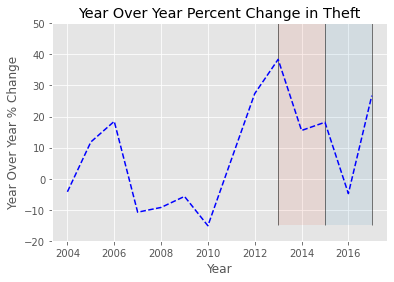

In [15]:
# Plot the year over year difference

plt.plot(auto_crime['year'], auto_crime['diff_absolute']*100, 'b--')
plt.title('Year Over Year Percent Change in Theft')
plt.xlabel('Year')
plt.ylabel('Year Over Year % Change')
plt.ylim(-20, 50)

# Add in vertical lines showing regions of comparison
plt.vlines(2013, -15, 50, linewidth=0.5)
plt.vlines(2015, -15, 50, linewidth=0.5)
plt.vlines(2017, -15, 50, linewidth=0.5)
plt.fill_betweenx(auto_crime['diff_absolute']*350, 2013, 2015, alpha=0.1)
plt.fill_betweenx(auto_crime['diff_absolute']*350, 2015, 2017, alpha=0.1)

plt.savefig('year-over-year', dpi=350)

## Looking at violent and non-violent crime in the Mission


My hypothesis was that violent crime in the Mission would decrease due to gentrification. I define the period of gentrification as 2012 onwards (strongest during the post recession recovery). 
My hypothesis is clearly wrong.

- Not only did violent crime stay relatively flat, non-violent crime decreased. 
- Violent crime a larger percentage of total crime. 
- We see the opposite trend outside of the mission: non-violent crime increased.
- Violent crime is a lower percentage of total crime outside the Mission. 

How to quantify this?

Calculate the mean crime rate pre 2012 vs post 2012?


In [16]:
mission_crime['fraction_viol_mision']

0     0.11230
1     0.12183
2     0.11721
3     0.13184
4     0.12930
5     0.12973
6     0.12889
7     0.11662
8     0.12764
9     0.14343
10    0.14669
11    0.13476
12    0.16126
13    0.14682
14    0.15460
Name: fraction_viol_mision, dtype: float64

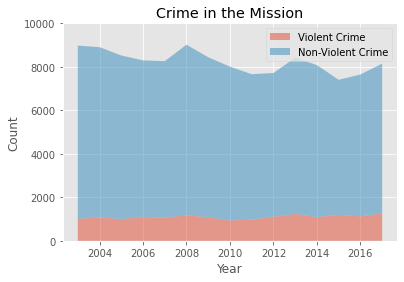

In [17]:
# Digging in a little more to look at absolute numbers
#helper.plotter_onegraph(mission_crime, 'year', ['viol_in_mission', 'nonviol_in_mission'], 'fraction_viol_mision')

#mission_crime['Total Violent Crime', 'Total Non-Violent Crime'].plot.area(alpha = 0.5)
plt.stackplot(mission_crime['year'], mission_crime['viol_in_mission'],
              mission_crime['nonviol_in_mission'], 
              labels=['Violent Crime', 'Non-Violent Crime'], alpha=0.5)
plt.legend()
plt.ylabel('Count')
plt.xlabel('Year')
plt.title("Crime in the Mission")
plt.ylim(0,10000)
plt.savefig('missioncrime.png', dpi=350)

# Now looking at time of day for crimes to be committed

Below are the data for crime by time of day. No distinguishing between violent and non-violent crime. 

Time ranges from 0 (midnight) to 23 (11:00 pm).

My hypothesis is that more crime is committed bewteen 8pm and midnight. I could change the hypothesis to say that crime by time of day DOES NOT follow a uniform distribution:

- H0: Crime rate per hour of the day follows a discrete uniform distribution.

- HA: Crime rate doesn't follow a discrete uniform distribution. 





In [18]:
crimetime = pd.read_csv('data/crimetime.csv')
crimetime

,year,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,2003,6785,3937,3519,2288,1572,1326,2104,3815,5844,...,7508,8049,8318,9107,9722,8563,7574,7553,7954,7558
1,2004,7308,3966,3382,2227,1565,1426,2152,3869,5932,...,7790,7847,8096,9112,9398,8058,7446,7551,8007,7485
2,2005,6993,3965,3391,2230,1637,1377,2135,3817,5964,...,7156,7495,7847,8797,8876,8007,7132,7032,7560,7095
3,2006,7001,3941,3431,2166,1486,1405,1998,3579,5526,...,7012,7544,7933,8357,8510,7428,6746,6695,7117,6744
4,2007,6851,4101,3449,2110,1516,1364,2065,3419,5259,...,7224,7459,7754,8424,8558,7617,6969,6834,7328,6702
5,2008,7626,4275,3625,2249,1617,1322,2252,3730,5310,...,7697,8060,8356,8753,8557,7517,7014,6742,7072,6738
6,2009,7648,4479,3947,2258,1602,1130,2239,3808,5298,...,7468,7767,8000,8198,8431,7238,6732,6706,7265,6526
7,2010,7501,4182,3555,2124,1475,1224,2008,3322,4825,...,6557,7314,7652,8157,8286,7682,6993,6479,7046,6609
8,2011,7831,4235,3608,2113,1500,1454,1998,3044,5003,...,6613,7155,7554,8002,8180,7283,6889,6440,6833,6727
9,2012,7790,4606,3588,2302,1579,1480,2139,3186,5035,...,6954,7845,8217,8752,9200,8152,7283,7047,7397,6634


Text(0, 0.5, 'Record Counts')

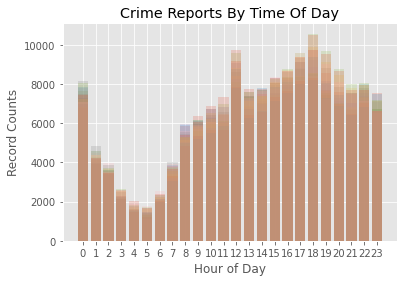

In [19]:
# Plot
labels = list(crimetime.columns)[1:]
for i in range(15):
    plt.bar(labels, height=list(crimetime.iloc[i,1:]), alpha=0.2, label=crimetime.iloc[i, 0])
plt.title("Crime Reports By Time Of Day")
plt.xlabel('Hour of Day')
plt.ylabel('Record Counts')
#plt.savefig('time_of_day.png', dpi=350)


## Day of Week!


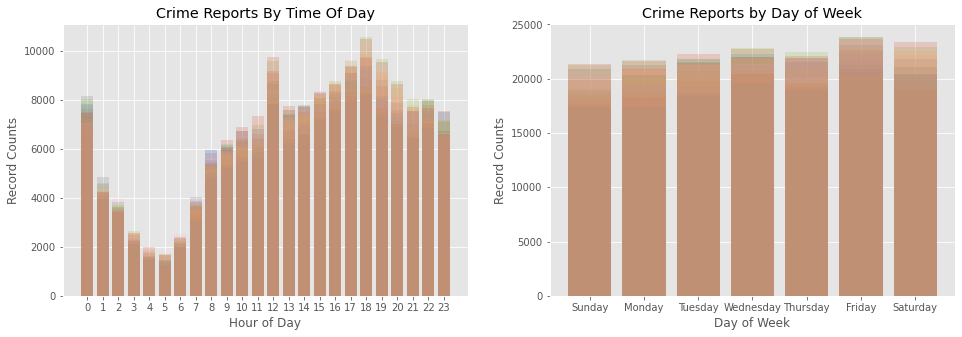

In [20]:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
counts = []

for year, data in zip(years, crime_years):
    dayofweekct = data.groupby('DayOfWeek').count().sort_values(by='Date', ascending=False)['Date']
    counts.append([dayofweekct[day] for day in days])

counts = pd.DataFrame(np.asarray(counts), columns=days)
counts['Year'] = years

fig, axes = plt.subplots(1,2, figsize=(16,5))

ax = axes[1]
for i in range(15):
    ax.bar(days, height=list(counts.iloc[i,:7]), alpha=0.2)
ax.set_xlabel('Day of Week')
#ax.xticks(rotation=45)
ax.set_title("Crime Reports by Day of Week")
ax.set_ylabel('Record Counts')
#plt.savefig('dayofweek.png',bbox_inches='tight', dpi=350)

ax = axes[0]
labels = list(crimetime.columns)[1:]
for i in range(15):
    ax.bar(labels, height=list(crimetime.iloc[i,1:]), alpha=0.2, label=crimetime.iloc[i, 0])
ax.set_title("Crime Reports By Time Of Day")
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Record Counts')

plt.savefig('crime_by_day_hour.png', bbox_inches='tight',dpi=350)

## Neighborhood Data

This is ultimatley useless data

In [23]:
income = pd.read_csv('data/Income_neighborhood.csv')
hoods = ['SOUTHERN', 'MISSION', 'NORTHERN', 'CENTRAL', 'BAYVIEW', 'INGLESIDE', 'TENDERLOIN',
 'TARAVAL', 'PARK', 'RICHMOND']
# Find total crime by year by neighborhood
crime_by_hood = pd.DataFrame()


for hood in hoods:
    crime_in_hood = []
    for data in crime_years:
        total_crime = len((data[data['PdDistrict'] == hood]).index)
        crime_in_hood.append(total_crime)
    crime_by_hood[hood] = pd.Series(crime_in_hood)


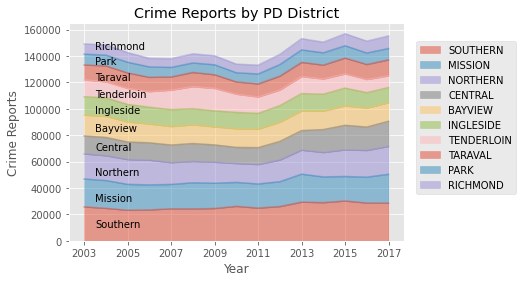

In [24]:
# Plot stacked plot by neighborhood. Probably not useful
crime_by_hood = crime_by_hood.set_index(pd.Index(years))
crime_by_hood.plot.area(alpha=0.5)
plt.title('Crime Reports by PD District')
plt.xlabel('Year')
plt.ylabel('Crime Reports')
plt.legend(loc='upper right', bbox_to_anchor=(1.350, 0.94))
plt.text(0.5,10000,'Southern', fontsize=10)
plt.text(0.5,30000,'Mission', fontsize=10)
plt.text(0.5,50000,'Northern', fontsize=10)
plt.text(0.5,69000,'Central', fontsize=10)
plt.text(0.5,83000,'Bayview', fontsize=10)
plt.text(0.5,97000,'Ingleside', fontsize=10)
plt.text(0.48,109000,'Tenderloin', fontsize=10)
plt.text(0.5,122000,'Taraval', fontsize=10)
plt.text(0.48,134000,'Park', fontsize=10)
plt.text(0.48,145000,'Richmond', fontsize=10)
plt.savefig('crime_bypddistrict.png', bbox_inches='tight', dpi=350)

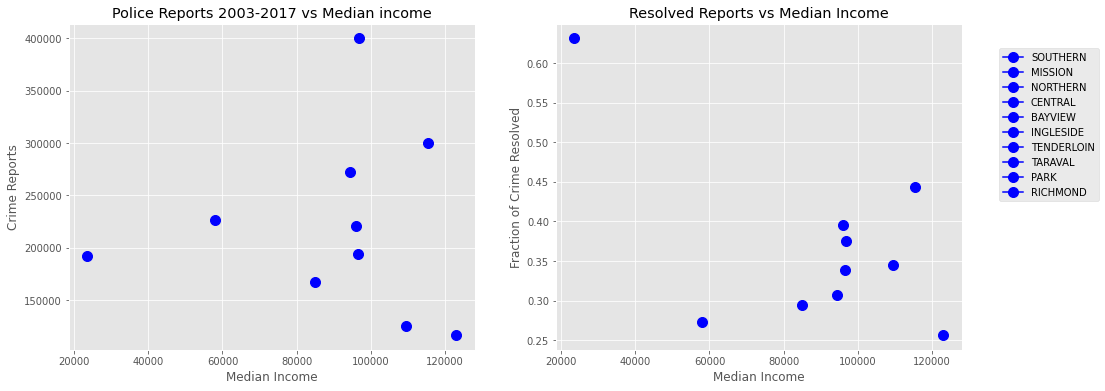

In [28]:
income_ = [97000, 115600,94411.4,58000, 95962, 96613.25, 23513, 84968.75, 109535, 123152.5]
reports = list(income['Total Police Reports'])
resolution_frac = list(income['Resoluiton Fraction'])


# Plot the data
fig, axes = plt.subplots(1,2, figsize=(16,6))

ax = axes[0]
for n, i in enumerate(hoods):
    ax.plot(income_[n], reports[n], label=i, marker='o', color='blue', markersize=10)   

ax.set_xlabel('Median Income')
ax.set_ylabel('Crime Reports')
ax.set_title('Police Reports 2003-2017 vs Median income')


ax = axes[1]
for n, i in enumerate(hoods):
    ax.plot(income_[n], resolution_frac[n], label=i, marker='o', color='blue', markersize=10)

ax.legend(loc='upper right', bbox_to_anchor=(1.350, 0.94))
ax.set_xlabel('Median Income')
ax.set_ylabel('Fraction of Crime Resolved')
ax.set_title('Resolved Reports vs Median Income')

plt.savefig('images/income_vs_crime.png', bbox_inches='tight',dpi=350)

